In [ ]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("⛳️ Google Colab environment")
else:
    root_dir = str(Path().absolute().parent.parent.parent)
    print("⛳️ Local environment")

# Add the root directory to the `PYTHONPATH` to use the `mlfs` Python module from the notebook.
if root_dir not in sys.path:
    print(f"Adding the following directory to the PYTHONPATH: {root_dir}")
    sys.path.append(root_dir)
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

In [1]:
import hopsworks
import joblib
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works/p/15479
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
feature_view = fs.get_feature_view("fraud_model_fv", 1)

In [4]:
X_train, X_test, y_train, y_test = feature_view.get_train_test_split(1)

In [5]:
X_train

,amount,category,time_delta_t_minus_1,loc_delta_t_minus_1,outside_city,cc_provider,cc_type,age,cc_expiration_days,count,min_amount,max_amount,mean
0,77.28,0,3.067859,0.239675,1,0,0,23.972603,1497,1,77.28,77.28,77.28
1,72.14,1,0.166285,0.147256,1,0,1,80.010959,1405,1,72.14,72.14,72.14
2,68.15,2,0.708333,0.000106,1,1,1,97.906849,1009,1,43.87,43.87,43.87
3,52.29,3,3.116053,0.439737,1,1,1,40.616438,1619,1,52.29,52.29,52.29
4,85.92,0,6.877488,0.206254,1,0,1,52.778082,1709,1,85.92,85.92,85.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36673,95.33,3,0.000000,0.000000,1,0,0,25.408219,1100,1,95.33,95.33,95.33
36674,32.69,2,0.433449,0.532246,1,1,0,84.747945,-117,1,1.75,1.75,1.75
36675,28.34,0,3.424468,0.366298,1,1,1,50.169863,1497,1,28.34,28.34,28.34
36676,1.29,0,0.143137,0.616324,1,1,0,29.663014,-25,1,1.29,1.29,1.29


In [6]:
# Create an instance of the XGBClassifier
clf = xgb.XGBClassifier()

# Fit the classifier on the training data
clf.fit(X_train.values, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [7]:
# Predict the training data using the trained classifier
y_pred_train = clf.predict(X_train.values)

# Predict the test data using the trained classifier
y_pred_test = clf.predict(X_test.values)

In [8]:
# Compute f1 score
metrics = {
    "f1_score": f1_score(y_test, y_pred_test, average='macro')
}
metrics

{'f1_score': 0.9736137383628204}

In [9]:
# Generate the confusion matrix using the true labels (y_test) and predicted labels (y_pred_test)
results = confusion_matrix(y_test, y_pred_test)

# Print the confusion matrix
print(results)

[[3547    0]
 [   1    9]]


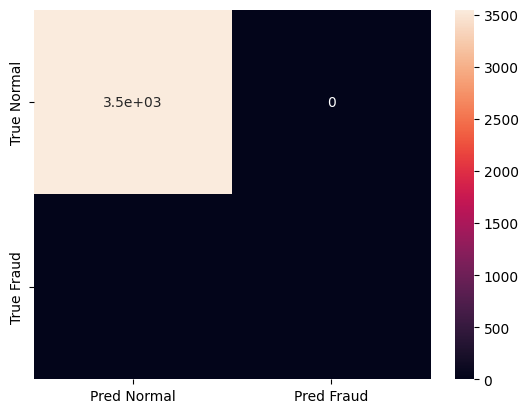

In [10]:
# Create a DataFrame from the confusion matrix results with appropriate labels
df_cm = pd.DataFrame(
    results, 
    ['True Normal', 'True Fraud'],
    ['Pred Normal', 'Pred Fraud'],
)

# Create a heatmap using seaborn with annotations
cm = sns.heatmap(df_cm, annot=True)

# Get the figure from the heatmap and display it
fig = cm.get_figure()
fig

In [11]:
# Register the model with the model registry
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Define the input schema using the values of X_train
input_schema = Schema(X_train.values)

# Define the output schema using y_train
output_schema = Schema(y_train)

# Create a ModelSchema object specifying the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Convert the model schema to a dictionary for further inspection or serialization
model_schema.to_dict()

{'input_schema': {'tensor_schema': {'shape': '(36678, 13)',
   'type': 'float64'}},
 'output_schema': {'columnar_schema': [{'name': 'fraud_label',
    'type': 'int64'}]}}

In [12]:
# Specify the directory where the model will be saved
model_dir = "fraud_model"

# Check if the directory exists, and create it if it doesn't
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained XGBoost model using joblib
joblib.dump(clf, model_dir + '/xgboost_fraud_model.pkl')

# Save the confusion matrix heatmap as an image in the model directory
images_dir = f"{model_dir}/images"
if not os.path.isdir(images_dir):
    os.mkdir(images_dir)
fig.savefig(images_dir + "/confusion_matrix.png")

In [13]:
# Get the model registry
mr = project.get_model_registry()

# Create a new model in the model registry
fraud_model = mr.python.create_model(
    name="xgboost_fraud_model",           # Name for the model
    metrics=metrics,                      # Metrics used for evaluation
    model_schema=model_schema,            # Schema defining the model's input and output
    input_example=X_train.sample(),       # Example input data for reference
    description="Fraud Predictor",        # Description of the model
)

# Save the model to the specified directory
fraud_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://snurran.hops.works/p/15479/models/xgboost_fraud_model/1


Model(name: 'xgboost_fraud_model', version: 1)